# Necessary libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import recall_score,  precision_score, confusion_matrix, f1_score, classification_report
from sklearn.utils import shuffle
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Importing the training data into the code

In [2]:
data = pd.read_csv("Training.csv", index_col = 'Id') 

# Find Whether data contains "NaN" entries

In [3]:
def print_full(x):
    '''
    function to print all the element in pandas series
    
    x - input series
    '''
    
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
print_full(data.isna().sum())

Product_Info_1             0
Product_Info_2             0
Product_Info_3             0
Product_Info_4             0
Product_Info_5             0
Product_Info_6             0
Product_Info_7             0
Ins_Age                    0
Ht                         0
Wt                         0
BMI                        0
Employment_Info_1         19
Employment_Info_2          0
Employment_Info_3          0
Employment_Info_4       6779
Employment_Info_5          0
Employment_Info_6      10854
InsuredInfo_1              0
InsuredInfo_2              0
InsuredInfo_3              0
InsuredInfo_4              0
InsuredInfo_5              0
InsuredInfo_6              0
InsuredInfo_7              0
Insurance_History_1        0
Insurance_History_2        0
Insurance_History_3        0
Insurance_History_4        0
Insurance_History_5    25396
Insurance_History_7        0
Insurance_History_8        0
Insurance_History_9        0
Family_Hist_1              0
Family_Hist_2          28656
Family_Hist_3 

# Correlated features

Some features in the data can be corelated to one another. Highly correlated features can be removed to avoid duclicity in the  data.

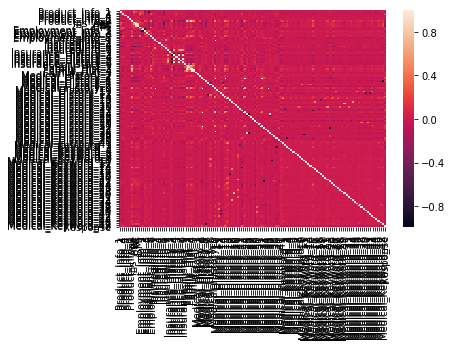

In [4]:
corr = data.iloc[:,:].corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

To drop the features that are in correlation with one another

In [5]:
data = data.drop(['Insurance_History_7','Medical_History_8','Medical_Keyword_45','Insurance_History_9', 'Family_Hist_3','Family_Hist_5'], axis =1)

# Dealing with missing values
missing entries in catagorical are replaced with the most recurring element in that particular column and missing element in continuous data is replaced my the median of the entire column

In [6]:
cat = ('Product_Info_1, Product_Info_2, Product_Info_3, Product_Info_5, Product_Info_6, Product_Info_7, Employment_Info_2, Employment_Info_3, Employment_Info_5, InsuredInfo_1, InsuredInfo_2, InsuredInfo_3, InsuredInfo_4, InsuredInfo_5, InsuredInfo_6, InsuredInfo_7, Insurance_History_1, Insurance_History_2, Insurance_History_3, Insurance_History_4, Insurance_History_7, Insurance_History_8, Insurance_History_9, Family_Hist_1, Medical_History_2, Medical_History_3, Medical_History_4, Medical_History_5, Medical_History_6, Medical_History_7, Medical_History_8, Medical_History_9, Medical_History_11, Medical_History_12, Medical_History_13, Medical_History_14, Medical_History_16, Medical_History_17, Medical_History_18, Medical_History_19, Medical_History_20, Medical_History_21, Medical_History_22, Medical_History_23, Medical_History_25, Medical_History_26, Medical_History_27, Medical_History_28, Medical_History_29, Medical_History_30, Medical_History_31, Medical_History_33, Medical_History_34, Medical_History_35, Medical_History_36, Medical_History_37, Medical_History_38, Medical_History_39, Medical_History_40, Medical_History_41').split(', ')
cont = ('Product_Info_4, Ins_Age, Ht, Wt, BMI, Employment_Info_1, Employment_Info_4, Employment_Info_6, Insurance_History_5, Family_Hist_2, Family_Hist_3, Family_Hist_4, Family_Hist_5').split(', ')
data['Product_Info_2'] = pd.factorize(data['Product_Info_2'])[0]
for col in data.columns:
    if int(data[col].isna().sum())>50000:
        data = data.drop(col, axis = 1)
    elif col in cat:
        data[col] = data[col].fillna(max(set(data[col]), key = list(data[col]).count))
    else:
        data[col] = data[col].fillna(data[col].median())
data.shape

(59381, 118)

# Feature selection
The most important features are identified by using SelectKBest algorithm with will related each and every features with the target value with a chi-square function.

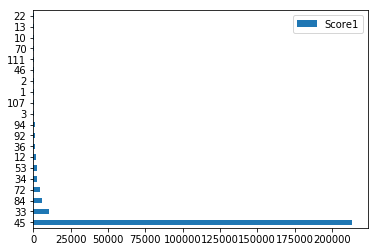

/home/lenovo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


                 Specs         Score1
45  Medical_History_15  213615.763599
33   Medical_History_1   10649.978487
84  Medical_Keyword_15    5639.405401
72   Medical_Keyword_3    4339.025870
34   Medical_History_2    2749.627783
53  Medical_History_23    2186.232874
12   Employment_Info_2    1462.347229
36   Medical_History_4    1181.399564
92  Medical_Keyword_23    1123.683820
94  Medical_Keyword_25     987.312671


In [7]:
X = pd.DataFrame(data).iloc[:,0:-2]  #independent columns
y = pd.DataFrame(data).iloc[:,-1]  
bestfeatures = SelectKBest(score_func=chi2, k=50)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score1']  #naming the dataframe columns
featureScores.nlargest(20,'Score1').plot(kind = 'barh') #plotting 20 best features
plt.show()
s1 = featureScores.nlargest(100,'Score1').iloc[:,0].as_matrix(columns=None)
print(featureScores.nlargest(100,'Score1').head(10))

new_data = data.copy()
for col in new_data.columns:
    if col not in s1:
        new_data = new_data.drop(col, axis = 1)
new_data['Response'] = data['Response']


# Remove outliers in the data
Data will usually contain outliers that will reduce the overall accuracy while training. the data whose standard deviation is greater than 3 than the entire data is removed

In [8]:
new_data = new_data[(np.abs(stats.zscore(new_data)) < 3).all(axis=1)]
new_data.shape

(19912, 101)

The entire data set is divided into two halves of ratio 8 : 2 as training and testing set

x_train -> train variables/ features

y_train -> train targets

x_test -> test variables/ features

y_test -> test targets

In [9]:
new_data = shuffle(new_data)
split = int(new_data.shape[0]*(80/100))
x_train = new_data.drop('Response', axis = 1).iloc[0:split,:]
y_train = new_data['Response'].iloc[0:split]
x_test = new_data.drop('Response', axis = 1).iloc[split:-1, :]
y_test = new_data['Response'].iloc[split:-1]

# Scaling the dataset
min-max scaling is used to scale the dataset to a come reference scale

In [10]:
scaler = MinMaxScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train))
x_test = pd.DataFrame(scaler.fit_transform(x_test))

From the plot below it can be identified that there is an imbalance in the distribution of data

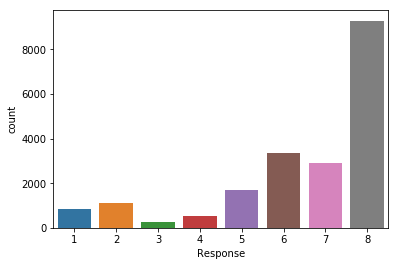

In [11]:
sns.countplot(new_data['Response'])

# Machine learning model

Random Forest model is used to map the data as the data contains imbalanced number of target variables.

Random forest with 60 trees, each at a maximum depth of 10 is employed

In [12]:
f = RandomForestClassifier(n_estimators=60,max_depth=10, min_samples_split=2, min_samples_leaf=3, bootstrap=False, oob_score=False, n_jobs=-1, random_state=1, verbose=0, warm_start=True, class_weight=None, max_features = "auto")
f.fit(x_train, y_train)
y_pred_test = f.predict(x_test)
y_pred_train = f.predict(x_train)

# Visualization of result

Confusion matrix, without normalization


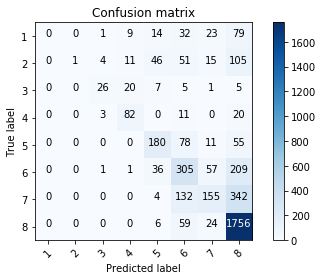

In [13]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
cnf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure()
plot_confusion_matrix(cnf_matrix,[1,2,3,4,5,6,7,8],
                      title='Confusion matrix')

# Evaluation Metrics

In [14]:
print ("Precision ->   "  +str(precision_score(y_pred_test, y_test, average="weighted")*100))
print ("Recall ->      "  +str(recall_score(y_pred_test, y_test, average="weighted")*100))
print ("F1 Accuracy -> "  +str(f1_score(y_pred_test, y_test, average="weighted")*100))

Precision ->   78.30266444014492
Recall ->      62.908086388749375
F1 Accuracy -> 68.68762315593764


/home/lenovo/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/lenovo/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


The model is saved locally for further deployment

In [15]:
import pickle as cPickle
with open('model.pkl', 'wb') as fid:
    cPickle.dump(f, fid)  